In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.15.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df = pd.read_csv("/content/TwitterSentiment_dataset.csv",encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [30]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [31]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [33]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

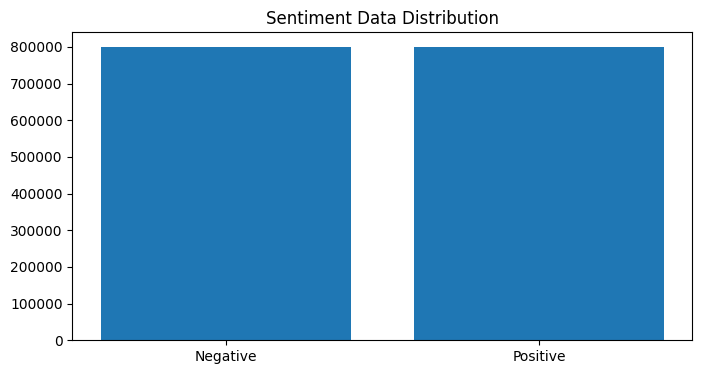

In [34]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [35]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [36]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [37]:
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [ ]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

In [ ]:
labels = train_data.sentiment.unique().tolist()

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(x_train.shape[1], 1)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train ,epochs=5)
prediction=model.predict(x_test)
y_predict=[]
for i in prediction:
    y_predict.append(np.argmax(i))
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
print('accuracy',round(accuracy_score(y_test,y_predict)*100,4),'%')
print('confusion matrix\n',confusion_matrix(y_test,y_predict))
print("classification report\n", classification_report(y_test, y_predict))

In [ ]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

prediction = model.predict(x_test)
y_predict = np.argmax(prediction, axis=1)

print("Classification Report:\n", classification_report(y_test, y_predict))

conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Data preprocessing code (x_train, y_train, x_test, y_test)

model = Sequential([
    Flatten(input_shape=(x_train.shape[1], 1)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

for epoch in range(5):
    print(f"Epoch {epoch + 1}/{5} - "
          f"Train Accuracy: {history.history['accuracy'][epoch]:.4f}, "
          f"Train Loss: {history.history['loss'][epoch]:.4f}, "
          f"Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}, "
          f"Validation Loss: {history.history['val_loss'][epoch]:.4f}")

prediction = model.predict(x_test)
y_predict = np.argmax(prediction, axis=1)

print('Test Set Metrics:')
print('Accuracy:', round(accuracy_score(y_test, y_predict) * 100, 4), '%')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predict))
print("Classification Report:\n", classification_report(y_test, y_predict))